Please note that this tutorial is focused at case study.  If you are interested in more technical details, please consult the other tutorials.

# Model

## Forward model

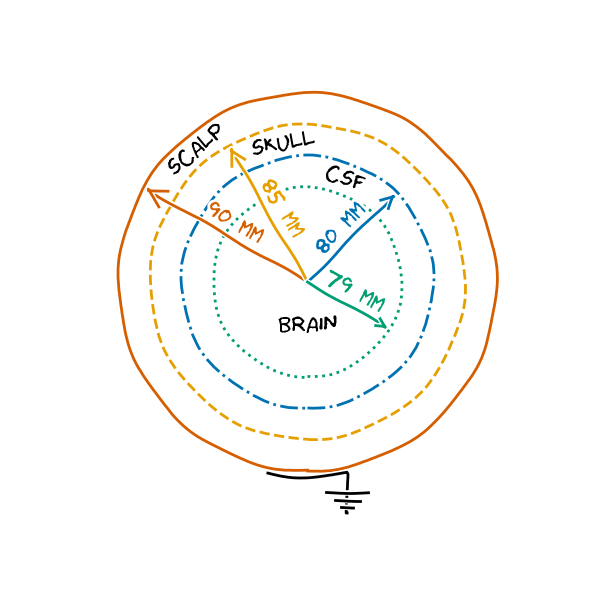

## Inverse model

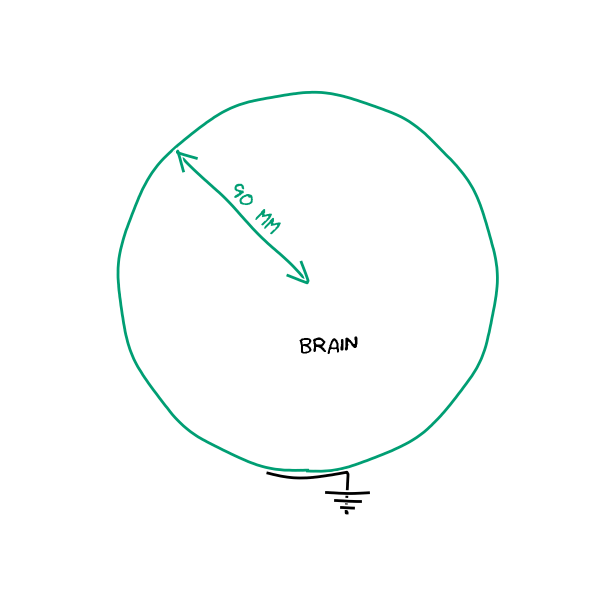

## Conductivities

| Volume | Forward      | Inverse      |
|:-------|:-------------|:-------------|
| Scalp  | 413.7 mS / m | n/a          |
| Skull  |  16.0 mS / m | n/a          |
| CSF    |  1710 mS / m | n/a          |
| Brain  | 374.6 mS / m | 330.0 mS / m |

# Requirements

## Memory

The code of the notebook requires at least 8.5 GB (8.0 GiB) of free memory.


## Environment

1. Anaconda Python distribution (tested with `Miniconda3-py39_4.12.0-Linux-x86_64.sh`, _conda v. 4.12.0_).
2. Jupyter server (see `extras/jupyter_server.sh` for details).
3. Anaconda environments (run `setup_conda_envs.sh`).
4. gmsh (not necessary if you already have meshes in either MSH or XDMF format).


## Setup

### Mesh for kESI

You need to have a mesh in XDMF format.  Luckily, the workflow defined in
`extras/Snakefile` creates it (if necessary) during preprocessing.



### Mesh for forward modelling

You will also need a mesh of slightly different geometry to simulate difference between assumed and actual brain.  Run:

    snakemake data/generated/meshes/four_spheres_csf_1_mm__plain/fine.xdmf -j 1

It may take a while<!-- (1-2 min)-->.  At least 209 MB (200 MiB) of free memory is necessary.

# Preprocessing

We are going to use:
  - the `data/bundled/electrode_locations/tutorial/case_study.ini` electrode positions,
  - the `data/generated/meshes/single_sphere__composite/normal.xdmf` mesh, and
  - the `data/bundled/model_properties/single_sphere__Naess_Chintaluri_2017.ini` properties.

The preprocessing workflow is defined in the `Snakefile` and we run it with `snakemake`:

    cd extras
    conda activate kesi3.7
    snakemake .tutorial_case_study_single_sphere -j 1 --resources mem_mb=15000 --restart-times 2

It may take a while (more than 2 h).  At least 236 MB (225 MiB) of free memory is necessary.
Ensure that you have enough diskspace (1.4 GB / 1.3 GiB) at the filesystem of the
`data/generated/tutorial/case_study_single_sphere/` directory.

> The `-j 1` parameter sets the number of jobs that can be run in parallel to 1.  If more
> CPU cores are available, you can increase that number to increase throughput, thus reduce
> the total preprocessing time.  But mind that in some systems (e.g. certain virtual machines)
> increase of paralellization beyond certain limit may significantly compromise performance.<!--
> It took about 10 days when run with `-j 2` on a dualcore virtual machine while only 6 days when run serially on a single core one.  The same physical machine was used in both cases.-->
> The `--resources mem_mb=15000` parameter tells the scheduler to possibly limit the total
> memory used by all simultaneous jobs to 15000 MiB.  You can adjust the parameter according to
> the value of the `-j` parameter and available free memory.  The scheduler limits the memory
> available for a job to 15000 MiB in case of calculating the leadfield correction,
> and to 7500 MiB in case of sampling the leadfield.  Both limits include about 2 GiB of safety
> margins.  Moreover, if a job fails, it is restarted (up to 2 times - given by
> the `--restart-times 2` parameter) with a doubled limit.

# Kernel construction 

## Electrode object

<!--
The implementation of the electrode object requires
(for the sake of performance) the _POT_ grid
to be a subset of the leadfield sampling grid.

```
from kesi.kernel.electrode import IntegrationNodesAtSamplingGrid as Electrode
```
-->

In [ ]:
from kesi.kernel.electrode import LinearlyInterpolatedLeadfieldCorrection as Electrode

# # The interpolation can be speeded up at the cost of precision by changing
# # the class to `NearestNeighbourInterpolatedLeadfieldCorrection`:
# from kesi.kernel.electrode import NearestNeighbourInterpolatedLeadfieldCorrection as Electrode

In [ ]:
import glob


electrodes = [Electrode(filename)
              for filename in glob.glob("data/generated/tutorial/case_study_single_sphere/sampled_leadfield_corrections/*.npz")]

In [ ]:
len(electrodes)

## Model source

We want to use CSD bases 20mm wide ($R = 10mm$).
<!-- We want to use CSD bases 19.6mm wide ($R = 9.8mm$).

```
SRC_R = 9.8e-3
```
-->

In [ ]:
from kesi.common import SphericalSplineSourceKCSD


SRC_R = 10e-3

spline_nodes = [SRC_R / 3, SRC_R]
spline_polynomials = [[1],
                      [0,
                       6.75 / SRC_R,
                       -13.5 / SRC_R ** 2,
                       6.75 / SRC_R ** 3]]
model_src = SphericalSplineSourceKCSD(0, 0, 0,
                                      spline_nodes,
                                      spline_polynomials)

## Convolver object

<!--
```
_pot_grid = electrodes[0].SAMPLING_GRID
```
-->

In [ ]:
import numpy as np

from kesi.kernel.constructor import Convolver


BRAIN_RADIUS = 0.079
ROMBERG_K = 4

_h_min = SRC_R * 2**(1 - ROMBERG_K)
_n_xy = int(np.floor(2 * BRAIN_RADIUS / _h_min)) + 1
_n_z = int(np.floor(1.5 * BRAIN_RADIUS / _h_min)) + 1

_X = _Y = np.linspace(-BRAIN_RADIUS, BRAIN_RADIUS, _n_xy)
_Z = np.linspace(-0.5 * BRAIN_RADIUS, BRAIN_RADIUS, _n_z)

_pot_grid = [_X, _Y, _Z]
_csd_grid = _pot_grid

convolver = Convolver(_pot_grid, _csd_grid)

## Convolver interface

We include only CSD bases which supports fit in the brain.
Additionaly we exclude bases at the very bottom of the brain.

In [ ]:
from kesi.kernel.constructor import ConvolverInterfaceIndexed

from scipy.integrate import romb


ROMBERG_N = 2**ROMBERG_K + 1
ROMBERG_WEIGHTS = romb(np.identity(ROMBERG_N),
                       dx=2**-ROMBERG_K)

SRC_MASK = ((convolver.SRC_Z > max(-0.06, -0.5 * BRAIN_RADIUS) + SRC_R)
            & (np.sqrt(np.square(convolver.SRC_X)
                       + np.square(convolver.SRC_Y)
                       + np.square(convolver.SRC_Z)) < BRAIN_RADIUS - SRC_R))

In [ ]:
print(SRC_MASK.sum())

In [ ]:
convolver_interface = ConvolverInterfaceIndexed(convolver,
                                                model_src.csd,
                                                ROMBERG_WEIGHTS,
                                                SRC_MASK)

## Potential Basis Functions object

### Potential Basis Functions: analytical solution of the forward problem (kCSD)

In [ ]:
from kesi.kernel import potential_basis_functions as pbf

In [ ]:
pbf_kcsd = pbf.Analytical(convolver_interface,
                          potential=model_src.potential)

### Potential Basis Functions: numerically corrected analytical solution of the forward problem (kESI)

In [ ]:
pbf_kesi = pbf.AnalyticalCorrectedNumerically(convolver_interface,
                                              potential=model_src.potential)

## (Cross)kernel constructors

In [ ]:
from kesi.kernel.constructor import KernelConstructor, CrossKernelConstructor


kernel_constructor = KernelConstructor()

In [ ]:
CSD_MASK = np.ones(convolver.shape('CSD'),
                   dtype=bool)

kernel_constructor.crosskernel = CrossKernelConstructor(convolver_interface,
                                                        CSD_MASK)

In [ ]:
def to_3D(CSD):
    return CSD.reshape(convolver.shape('CSD'))

# kCSD reconstructor

## Construction of kernels

In [ ]:
%%time
B_KCSD = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kcsd)

In [ ]:
%%time
KERNEL_KCSD = kernel_constructor.kernel(B_KCSD)

In [ ]:
%%time
CROSSKERNEL_KCSD = kernel_constructor.crosskernel(B_KCSD)

It may take more than half a minute.

In [ ]:
del B_KCSD  # the array is large and no longer needed

## Reconstructor object

In [ ]:
from kesi import Reconstructor


reconstructor_kcsd = Reconstructor(KERNEL_KCSD,
                                   CROSSKERNEL_KCSD)

# Visualisation

In [ ]:
import matplotlib.pyplot as plt

from local import cbf
from local.tutorial.view import CaseStudy as CoordinatePlanesVisualisation

In [ ]:
csd_plotter = CoordinatePlanesVisualisation(convolver.CSD_GRID,
                                            [-0.05, 0.015, -0.02],
                                            unit_factor=1e-3,
                                            unit='$\\frac{pA}{mm^3}$',
                                            length_factor=1e3,
                                            length_unit='$mm$')

# Ground Truth CSD and its electric field

## GT CSD

In [ ]:
from local.tutorial import eigh


EIGENVALUES_KCSD, EIGENVECTORS_KCSD = eigh(KERNEL_KCSD)

GT_CSD = 100 * to_3D(reconstructor_kcsd(EIGENVECTORS_KCSD[:, 2]))

In [ ]:
csd_plotter.plot_volume(GT_CSD, 'GT CSD')

## FEM forward modelling

In [ ]:
import scipy.interpolate as si

from local.tutorial import SphericalForwardModel as ForwardModel

To simulate the differences between actual and assumed head geometries, we use model with thinner CSF layer for forward modelling.  Also, the conductivities are different.  We use the weighted average values from [Variation in Reported Human Head Tissue Electrical Conductivity Values (McCann 2019)](https://doi.org/10.1007/s10548-019-00710-2).

In [ ]:
%%time
fem = ForwardModel(mesh="data/generated/meshes/four_spheres_csf_1_mm__plain/fine.xdmf",
                   degree=1,
                   config="data/bundled/model_properties/four_spheres_csf_1_mm__McCann_2019.ini")

In [ ]:
%%time
_csd_grid = [_x.flatten() for _x in convolver.CSD_GRID]
_csd = si.RegularGridInterpolator(_csd_grid,
                                  GT_CSD,
                                  bounds_error=False,
                                  fill_value=0)
potential = fem(_csd)

del _csd  # the object is large and no longer needed

We visualise the potential.

In [ ]:
potential_plotter = CoordinatePlanesVisualisation(convolver.CSD_GRID,
                                                  [-0.05, 0.015, -0.02],
                                                  unit='$\mu{}V$',
                                                  length_factor=1e3,
                                                  length_unit='$mm$',
                                                  cmap=cbf.PRGn)

In [ ]:
%%time
potential_plotter.plot_function(potential, 'POTENTIAL')

We probe the potential at electrodes.

In [ ]:
GT_V = np.array([potential(_e.x, _e.y, _e.z) for _e in electrodes])

In [ ]:
del potential, fem  # these objects are large and no longer needed

To make the case more realistic we introduce 1% noise.

In [ ]:
np.random.seed(42)
NOISE_V = np.random.normal(loc=GT_V,
                           scale=0.01 * GT_V.std())

# Reconstruction

## kCSD

As the ground truth CSD is a kCSD eigensource, kCSD is (theoretically) able to reconstruct it exactly.  But the forward model does not conform to assumptions of kCSD, which may lead to reconstruction artifacts.

In [ ]:
CSD_KCSD = to_3D(reconstructor_kcsd(NOISE_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KCSD,
                            'kCSD')

As you can see, the reconstruction is mostly error.

In [ ]:
del CSD_KCSD  # the array is large and no longer needed

## Regularization

### Leave-one-out cross-validation

In [ ]:
plt.plot(EIGENVALUES_KCSD)
plt.yscale('log')

In [ ]:
REGULARIZATION_PARAMETERS = np.logspace(-2, 15, 17 * 10 + 1)

assert REGULARIZATION_PARAMETERS.min() <= EIGENVALUES_KCSD.min()
assert EIGENVALUES_KCSD.max() <= REGULARIZATION_PARAMETERS.max()

In [ ]:
from kesi.common import cv

In [ ]:
%%time
CV_ERRORS_KCSD = cv(reconstructor_kcsd, NOISE_V, REGULARIZATION_PARAMETERS)

It may take more than two hours if other tasks are running.  Otherwise it may take less than a minute.

In [ ]:
regularization_parameter_kcsd = REGULARIZATION_PARAMETERS[np.argmin(CV_ERRORS_KCSD)]

In [ ]:
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS_KCSD,
         color=cbf.BLUE)
plt.plot(regularization_parameter_kcsd,
         min(CV_ERRORS_KCSD),
         marker="o",
         color=cbf.BLUE)
plt.axvspan(EIGENVALUES_KCSD.min(),
            EIGENVALUES_KCSD.max(),
            ls=":",
            color=cbf.GREEN,
            hatch=".....",
            fill=False)
plt.xlabel('regularization parameter')
plt.xscale('log')
plt.ylabel('L2 norm of cross-validation error')
plt.yscale('log')

### L-curve parameter validation

In [ ]:
from local.tutorial.view import LCurvePlotter


plot_lcurve = LCurvePlotter(REGULARIZATION_PARAMETERS)
plot_lcurve(KERNEL_KCSD, NOISE_V,
            cv_selected_parameter=regularization_parameter_kcsd,
            horizontal_offset=-25)

There is no obvoious "knee" of the curve.

## Regularized kCSD

In [ ]:
CSD_KCSD_CV = to_3D(reconstructor_kcsd(NOISE_V,
                                       regularization_parameter_kcsd))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KCSD_CV,
                            'kCSD (regularized)')

The reconstruction is still mostly error.

In [ ]:
del CSD_KCSD_CV  # the array is large and no longer needed

In [ ]:
del reconstructor_kcsd, CROSSKERNEL_KCSD  # These objects are large and no longer needed

## Unregularized kESI

In [ ]:
%%time
B_KESI = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                    pbf_kesi)

It may take more than 2 minutes.

In [ ]:
%%time
KERNEL_KESI = kernel_constructor.kernel(B_KESI)

In [ ]:
%%time
CROSSKERNEL_KESI = kernel_constructor.crosskernel(B_KESI)

It may take more than half a minute.

In [ ]:
del B_KESI  # the array is large and no longer needed

In [ ]:
reconstructor_kesi = Reconstructor(KERNEL_KESI,
                                   CROSSKERNEL_KESI)

In [ ]:
CSD_KESI = to_3D(reconstructor_kesi(NOISE_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI,
                            'kESI')

As you can see, the unregularized kESI reconstruction
somehow resembles the ground truth, but is still mostly
error.

In [ ]:
del CSD_KESI  # the array is large and no longer needed

## Regularized kESI

In [ ]:
EIGENVALUES_KESI, _ = eigh(KERNEL_KESI)

assert REGULARIZATION_PARAMETERS.min() <= EIGENVALUES_KESI.min()
assert EIGENVALUES_KESI.max() <= REGULARIZATION_PARAMETERS.max()

In [ ]:
plt.plot(EIGENVALUES_KCSD, label='kCSD', ls='-')
plt.plot(EIGENVALUES_KESI, label='kESI', ls=':')
plt.legend(loc='upper right')
plt.yscale('log')

In [ ]:
%%time
CV_ERRORS_KESI = cv(reconstructor_kesi, NOISE_V, REGULARIZATION_PARAMETERS)

It may take more than 2 hours if other tasks are running.  Otherwise it may take less than a minute.

In [ ]:
regularization_parameter_kesi = REGULARIZATION_PARAMETERS[np.argmin(CV_ERRORS_KESI)]

In [ ]:
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS_KCSD,
         color=cbf.BLUE,
         label='kCSD')
plt.plot(regularization_parameter_kcsd,
         min(CV_ERRORS_KCSD),
         marker="o",
         color=cbf.BLUE)
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS_KESI,
         color=cbf.VERMILION,
         label='kESI')
plt.plot(regularization_parameter_kesi,
         min(CV_ERRORS_KESI),
         marker="o",
         color=cbf.VERMILION)
plt.axvspan(min(EIGENVALUES_KCSD.min(), EIGENVALUES_KESI.min()),
            max(EIGENVALUES_KESI.max(), EIGENVALUES_KESI.max()),
            ls=":",
            color=cbf.GREEN,
            hatch=".....",
            fill=False)
plt.legend(loc='lower right')
plt.xlabel('regularization parameter')
plt.xscale('log')
plt.ylabel('L2 norm of cross-validation error')
plt.yscale('log')

### L-curve parameter validation and selection

In [ ]:
plot_lcurve(KERNEL_KESI, NOISE_V,
            cv_selected_parameter=regularization_parameter_kesi,
            horizontal_offset=-50)

There are two "knees" of the curve, one of which is selected
by cross-validation.

In [ ]:
CSD_KESI_CV = to_3D(reconstructor_kesi(NOISE_V,
                                       regularization_parameter_kesi))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_CV,
                            'kESI (regularized)')

kESI reconstruction definitely benefitted from regularization.

In [ ]:
del CSD_KESI_CV  # the array is large and no longer needed